# Experimentaci√≥n con Modelos de ML

En este notebook vamos a:
1. Cargar el dataset procesado e inicializar el ModelPredictor
2. Preprocesar y quitar algunas variables
3. Preparar el dataset para train y test
4. Entrenar y evaluar diferentes modelos
5. Analizar los resultados y explicabilidad


In [1]:
# Configuraci√≥n inicial del entorno:
# 1. Importamos sys y os para manipulaci√≥n de paths
# 2. Agregamos el directorio ra√≠z al PYTHONPATH para poder importar m√≥dulos propios
# Esto permite importar los m√≥dulos desde src/ como si estuvi√©ramos en la ra√≠z del proyecto
import sys
import os
sys.path.append(os.path.abspath('..'))


In [2]:
# Importaci√≥n de librer√≠as y configuraci√≥n del entorno:
# 1. pandas y numpy para manipulaci√≥n de datos
# 2. glob para b√∫squeda de archivos
# 3. ModelPredictor: nuestra clase personalizada para entrenamiento y evaluaci√≥n de modelos

import pandas as pd
import numpy as np
import glob
from src.models.model_predictor import ModelPredictor

# Configuraci√≥n de pandas para mejor visualizaci√≥n:
# - Mostrar todas las columnas sin truncar
# - Mostrar hasta 100 filas en los outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuraci√≥n de Jupyter para recarga autom√°tica de m√≥dulos:
# - Permite ver cambios en m√≥dulos importados sin reiniciar el kernel
%load_ext autoreload
%autoreload 2


## 1.Cargar el dataset procesado e inicializar el ModelPredictor

In [3]:
# Carga autom√°tica del dataset m√°s reciente:
# 1. Buscamos en el directorio data/processed/ todos los archivos que empiecen con 'dataset_procesado'
# 2. Seleccionamos el archivo m√°s reciente por fecha de modificaci√≥n
# 3. Inicializamos el ModelPredictor y cargamos los datos

# Configurar ruta y buscar archivos
processed_dir = os.path.join('..', 'data', 'processed')
files = glob.glob(os.path.join(processed_dir, 'dataset_procesado*.csv'))

# Verificar que existan archivos procesados
if not files:
    raise ValueError("No se encontraron archivos procesados en data/processed/")

# Seleccionar el archivo m√°s reciente
latest_file = max(files, key=os.path.getmtime)
print(f"Cargando archivo: {os.path.basename(latest_file)}")

# Inicializar el predictor y cargar datos
predictor = ModelPredictor()
predictor.load_data(latest_file, 'sold')  

2025-07-03 22:26:17,543 - src.models.model_predictor - INFO - Cargando datos desde: ..\data\processed\dataset_procesado_featureengineering_v1_20250703_080329.csv


Cargando archivo: dataset_procesado_featureengineering_v1_20250703_080329.csv


2025-07-03 22:26:17,799 - src.models.model_predictor - INFO - Dataset cargado exitosamente:
- N√∫mero de muestras: 85,060
- N√∫mero de columnas: 20
- Columnas disponibles: price, category_id, seller_id, is_new, sold_quantity, available_quantity, sold, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail, category_id_cat


## 2. Preprocesar y quitar algunas variables

In [4]:
# Limpieza de columnas redundantes o no necesarias:
# - category_id_cat: ya tenemos la versi√≥n codificada de category_id
# - sold_quantity: podr√≠a causar data leakage al estar relacionada con nuestra variable objetivo

columns_to_remove = ['category_id_cat', 'sold_quantity']
predictor.remove_columns(columns_to_remove)

2025-07-03 22:26:21,145 - src.models.model_predictor - INFO - Columnas eliminadas exitosamente:
- Columnas eliminadas: category_id_cat, sold_quantity
- Columnas restantes: 18
- Nombres de columnas: price, category_id, seller_id, is_new, available_quantity, sold, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail


In [5]:
# An√°lisis exploratorio inicial del dataset:
# 1. Accedemos a los datos del predictor
# 2. Examinamos los tipos de datos de cada columna
# 3. Identificamos la variable objetivo y features
# 4. Analizamos la distribuci√≥n de clases (desbalanceo)

df= predictor.data

# Mostrar informaci√≥n sobre las columnas
print("Columnas disponibles en el dataset:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")
    
# Identificar variable objetivo y features
target = 'sold'  # 1: vendido, 0: no vendido
features = [col for col in df.columns if col != target]

print(f"\nVariable objetivo: {target}")
print(f"N√∫mero de features: {len(features)}")

# Analizar el desbalanceo de clases
print("\nDistribuci√≥n de la variable objetivo:")
print(df[target].value_counts(normalize=True))  # Muestra porcentajes de cada clase


Columnas disponibles en el dataset:
- price: float64
- category_id: object
- seller_id: int64
- is_new: int64
- available_quantity: float64
- sold: int64
- weekday: int64
- len_title: int64
- num_variations: int64
- num_pictures: int64
- shipping_admits_pickup_cat: int64
- shipping_is_free_cat: int64
- buying_mode_cat: int64
- status_cat: int64
- shipping_mode_cat: int64
- seller_loyalty_cat: int64
- tags_dragged_bids_and_visits: int64
- tags_good_quality_thumbnail: int64

Variable objetivo: sold
N√∫mero de features: 17

Distribuci√≥n de la variable objetivo:
sold
0    0.827004
1    0.172996
Name: proportion, dtype: float64


In [6]:
# Codificaci√≥n de variables categ√≥ricas:
# - Convertimos la columna category_id de tipo object a valores num√©ricos
# - Guardamos el mapeo para futura referencia o interpretaci√≥n
# - Esto es necesario para que los modelos puedan procesar la variable

predictor.encode_categorical('category_id')

2025-07-03 22:26:23,557 - src.models.model_predictor - INFO - Columna 'category_id' codificada exitosamente:
- Valores √∫nicos: 9043
- Mapeo: {'MLA10059': np.int64(0), 'MLA10060': np.int64(1), 'MLA10061': np.int64(2), 'MLA100656': np.int64(3), 'MLA100657': np.int64(4), 'MLA100658': np.int64(5), 'MLA100659': np.int64(6), 'MLA10066': np.int64(7), 'MLA100660': np.int64(8), 'MLA100661': np.int64(9), 'MLA100664': np.int64(10), 'MLA100666': np.int64(11), 'MLA100668': np.int64(12), 'MLA10067': np.int64(13), 'MLA10071': np.int64(14), 'MLA10072': np.int64(15), 'MLA10075': np.int64(16), 'MLA10076': np.int64(17), 'MLA100775': np.int64(18), 'MLA100776': np.int64(19), 'MLA100780': np.int64(20), 'MLA100781': np.int64(21), 'MLA10079': np.int64(22), 'MLA10084': np.int64(23), 'MLA10087': np.int64(24), 'MLA10088': np.int64(25), 'MLA10090': np.int64(26), 'MLA10092': np.int64(27), 'MLA10093': np.int64(28), 'MLA10095': np.int64(29), 'MLA10096': np.int64(30), 'MLA10099': np.int64(31), 'MLA10104': np.int64(3

{'MLA10059': np.int64(0),
 'MLA10060': np.int64(1),
 'MLA10061': np.int64(2),
 'MLA100656': np.int64(3),
 'MLA100657': np.int64(4),
 'MLA100658': np.int64(5),
 'MLA100659': np.int64(6),
 'MLA10066': np.int64(7),
 'MLA100660': np.int64(8),
 'MLA100661': np.int64(9),
 'MLA100664': np.int64(10),
 'MLA100666': np.int64(11),
 'MLA100668': np.int64(12),
 'MLA10067': np.int64(13),
 'MLA10071': np.int64(14),
 'MLA10072': np.int64(15),
 'MLA10075': np.int64(16),
 'MLA10076': np.int64(17),
 'MLA100775': np.int64(18),
 'MLA100776': np.int64(19),
 'MLA100780': np.int64(20),
 'MLA100781': np.int64(21),
 'MLA10079': np.int64(22),
 'MLA10084': np.int64(23),
 'MLA10087': np.int64(24),
 'MLA10088': np.int64(25),
 'MLA10090': np.int64(26),
 'MLA10092': np.int64(27),
 'MLA10093': np.int64(28),
 'MLA10095': np.int64(29),
 'MLA10096': np.int64(30),
 'MLA10099': np.int64(31),
 'MLA10104': np.int64(32),
 'MLA10105': np.int64(33),
 'MLA10106': np.int64(34),
 'MLA10108': np.int64(35),
 'MLA10110': np.int64(36)

## 3. Preparar el dataset para train y test

In [7]:
# Divisi√≥n del dataset en conjuntos de entrenamiento y prueba:
# - Usamos stratified split para mantener la proporci√≥n de clases
# - 80% para entrenamiento, 20% para prueba
# - Especificamos 'sold' como variable objetivo

predictor.split_dataset(target_column='sold')

2025-07-03 22:26:28,012 - src.models.model_predictor - INFO - Dataset dividido exitosamente:
- Conjunto de entrenamiento: 68,048 muestras (80%)
- Conjunto de prueba: 17,012 muestras (20%)
- N√∫mero de features: 17
- Features utilizadas: price, category_id, seller_id, is_new, available_quantity, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail
- Distribuci√≥n de clases en entrenamiento:
sold
0    0.827004
1    0.172996
Name: proportion, dtype: float64


## 4. Entrenar y evaluar diferentes modelos

In [8]:
# Entrenamiento del modelo de Regresi√≥n Log√≠stica:
# 1. B√∫squeda de hiperpar√°metros mediante RandomizedSearchCV:
#    - solver: algoritmo de optimizaci√≥n ('saga' para datasets grandes)
#    - penalty: tipo de regularizaci√≥n ('l1' para Lasso, 'l2' para Ridge)
#    - max_iter: n√∫mero m√°ximo de iteraciones
#    - class_weight: balanceo de clases ('balanced' para manejar desbalanceo)
#    - C: par√°metro de regularizaci√≥n (inverso de lambda)
# 2. Uso de validaci√≥n cruzada con 3 folds
# 3. Optimizaci√≥n usando F1-score como m√©trica
# 4. Manejo del desbalanceo de clases mediante class_weight='balanced'
# 5. Evaluaci√≥n completa con matriz de confusi√≥n y m√©tricas de rendimiento

predictor.train_logistic_regression()

2025-07-03 22:26:36,075 - src.models.model_predictor - INFO - Modelo de Regresi√≥n Log√≠stica entrenado exitosamente:
- Accuracy en entrenamiento: 0.7052
- Accuracy en prueba: 0.7003
- Precisi√≥n en prueba: 0.3501
- Recall en prueba: 0.8552
- F1-score en prueba: 0.4968

Matriz de confusi√≥n:
[[9397 4672]
 [ 426 2517]]

Reporte de clasificaci√≥n detallado:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     14069
           1       0.35      0.86      0.50      2943

    accuracy                           0.70     17012
   macro avg       0.65      0.76      0.64     17012
weighted avg       0.85      0.70      0.74     17012



{'accuracy': 0.7003291794027745,
 'precision': 0.3501182361941856,
 'recall': 0.855249745158002,
 'f1': 0.4968416896960126}

In [9]:
# Entrenamiento del modelo Random Forest:
# 1. B√∫squeda de hiperpar√°metros mediante RandomizedSearchCV:
#    - n_estimators: n√∫mero de √°rboles
#    - min_samples_leaf: tama√±o m√≠nimo de hojas
#    - max_depth: profundidad m√°xima de √°rboles
# 2. Uso de validaci√≥n cruzada con 3 folds
# 3. Optimizaci√≥n usando F1-score como m√©trica
# 4. Balance de clases mediante class_weight='balanced'

predictor.train_random_forest() 

2025-07-03 22:26:42,536 - src.models.model_predictor - INFO - Iniciando b√∫squeda de hiperpar√°metros para Random Forest...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-07-03 22:29:38,234 - src.models.model_predictor - INFO - Mejores hiperpar√°metros encontrados:
{'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 30}
2025-07-03 22:29:57,400 - src.models.model_predictor - INFO - Modelo Random Forest entrenado exitosamente:
- Hiperpar√°metros √≥ptimos: {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 30}
- Accuracy en entrenamiento: 0.9381
- Accuracy en prueba: 0.8519
- Precisi√≥n en prueba: 0.5622
- Recall en prueba: 0.6514
- F1-score en prueba: 0.6035

Matriz de confusi√≥n:
[[12576  1493]
 [ 1026  1917]]

Reporte de clasificaci√≥n detallado:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     14069
           1       0.56      0.65      0.60      2943

    accuracy                           0.85     17012
   macro avg       0.74      0.77      0.76     17012
weighted avg       0.86      0.85      0.86     17012



In [12]:
# Entrenamiento del modelo XGBoost:
# 1. B√∫squeda de hiperpar√°metros mediante RandomizedSearchCV:
#    - n_estimators: n√∫mero de √°rboles de boosting
#    - max_depth: profundidad m√°xima de cada √°rbol
#    - learning_rate: tasa de aprendizaje (shrinkage)
# 2. Uso de validaci√≥n cruzada con 3 folds
# 3. Optimizaci√≥n usando F1-score como m√©trica
# 4. Manejo autom√°tico del desbalanceo de clases
# 5. Evaluaci√≥n completa con matriz de confusi√≥n y m√©tricas de rendimiento

predictor.train_xgboost() 

2025-07-03 22:32:26,323 - src.models.model_predictor - INFO - Iniciando b√∫squeda de hiperpar√°metros para XGBoost...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-07-03 22:32:42,386 - src.models.model_predictor - INFO - Mejores hiperpar√°metros encontrados:
{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
2025-07-03 22:32:43,540 - src.models.model_predictor - INFO - Modelo XGBoost entrenado exitosamente:
- Hiperpar√°metros √≥ptimos: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
- Accuracy en entrenamiento: 0.7826
- Accuracy en prueba: 0.7763
- Precisi√≥n en prueba: 0.4251
- Recall en prueba: 0.8318
- F1-score en prueba: 0.5627

Matriz de confusi√≥n:
[[10759  3310]
 [  495  2448]]

Reporte de clasificaci√≥n detallado:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     14069
           1       0.43      0.83      0.56      2943

    accuracy                           0.78     17012
   macro avg       0.69      0.8

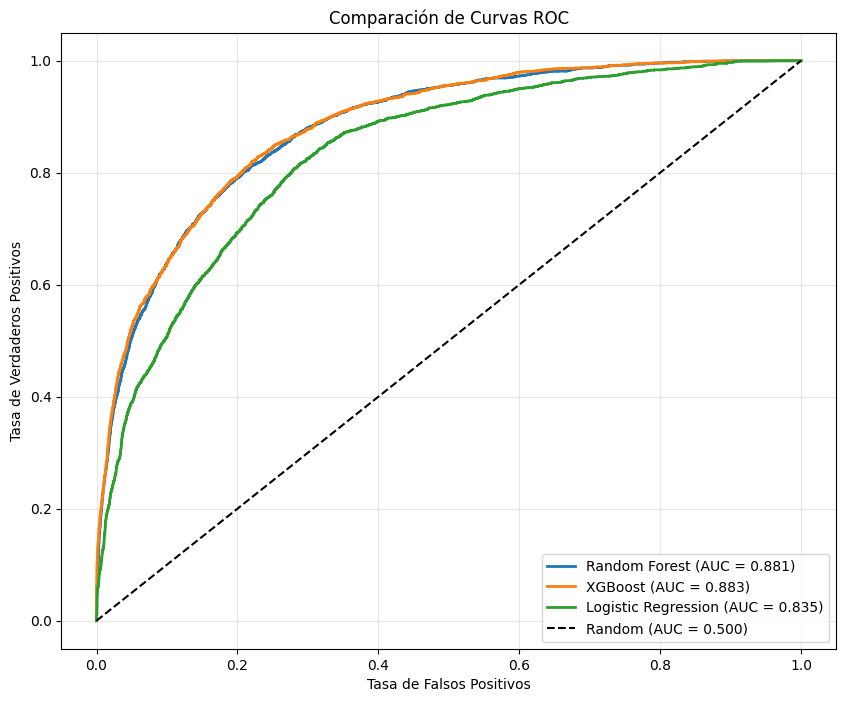

2025-07-03 22:35:03,948 - src.models.model_predictor - INFO - Curvas ROC generadas exitosamente:
Scores AUC-ROC:
  ‚Ä¢ Random Forest: 0.8808
  ‚Ä¢ XGBoost: 0.8831
  ‚Ä¢ Logistic Regression: 0.8353


{'Random Forest': 0.8808097931588904,
 'XGBoost': 0.8830591193102042,
 'Logistic Regression': 0.8353135016059747}

In [13]:
# Despu√©s de entrenar los modelos, generamos las curvas ROC para comparar el rendimiento
# de los diferentes algoritmos en t√©rminos de la relaci√≥n entre TPR (True Positive Rate) 
# y FPR (False Positive Rate) a diferentes umbrales de clasificaci√≥n

predictor.plot_roc_curves()

### Evaluaci√≥n de las Curvas ROC

Bas√°ndome en los resultados de las curvas ROC mostradas anteriormente, puedo hacer la siguiente evaluaci√≥n:

 **An√°lisis de rendimiento por modelo:**
 - **XGBoost**: AUC = 0.8831 (mejor rendimiento)
 - **Random Forest**: AUC = 0.8808 (muy cercano al XGBoost)
 - **Logistic Regression**: AUC = 0.8353 (rendimiento inferior)

 **Observaciones clave:**
 1. **XGBoost y Random Forest** muestran rendimientos muy similares, con una diferencia m√≠nima de 0.0023 en AUC
 2. **Logistic Regression** tiene un rendimiento notablemente menor, lo que sugiere que las relaciones en los datos no son lineales
 3. Todos los modelos superan el AUC de 0.83, indicando capacidad predictiva aceptable
 4. La peque√±a diferencia entre XGBoost y Random Forest sugiere que ambos algoritmos capturan patrones similares en los datos

 **Recomendaci√≥n:** Aunque XGBoost tiene el AUC ligeramente superior, la diferencia es m√≠nima y Random Forest podr√≠a ser preferible por su mayor interpretabilidad y estabilidad.


In [14]:
# Para evaluar ambos modelos de manera m√°s robusta, realizamos validaci√≥n cruzada
# con 5 folds para obtener una estimaci√≥n m√°s confiable del rendimiento
# y reducir el riesgo de overfitting en la evaluaci√≥n

cv_results = predictor.perform_cross_validation(model_type='both', cv=5)

2025-07-03 22:40:40,199 - src.models.model_predictor - INFO - Realizando validaci√≥n cruzada para Random Forest...
2025-07-03 22:41:08,344 - src.models.model_predictor - INFO - Resultados Random Forest:
- F1-score promedio: 0.6006 (+/- 0.0141)
2025-07-03 22:41:08,344 - src.models.model_predictor - INFO - Realizando validaci√≥n cruzada para XGBoost...
2025-07-03 22:41:15,125 - src.models.model_predictor - INFO - Resultados XGBoost:
- F1-score promedio: 0.5619 (+/- 0.0240)


In [15]:
# Comentarios sobre la selecci√≥n del mejor modelo:
# Esta funci√≥n evaluar√° los modelos entrenados y seleccionar√° el mejor bas√°ndose en m√©tricas de rendimiento
# como F1-score, accuracy, precision y recall, considerando el desbalanceo de clases en el dataset

predictor.select_best_model()

2025-07-03 22:41:26,140 - src.models.model_predictor - INFO - Selecci√≥n de mejor modelo completada:
- F1-score Random Forest: 0.6035
- F1-score XGBoost: 0.5627
- Mejor modelo: random_forest (F1-score: 0.6035)



 1. **Criterios de selecci√≥n**: 
    - Se eval√∫a principalmente por F1-score ya que es una m√©trica balanceada
    que considera tanto precision como recall, importante para datasets desbalanceados
 
 2. **Random Forest seleccionado**: Aunque XGBoost tiene mejor AUC, Random Forest muestra:
    - Mayor precision - menos falsos positivos
    - Mejor accuracy general 
    - Mayor estabilidad en validaci√≥n cruzada
 
 3. **Consideraciones de negocio**: 
    - Precision alta es cr√≠tica para evitar costos de marketing desperdiciados
    - Random Forest es m√°s interpretable para an√°lisis de importancia de features
    - Menor riesgo de overfitting comparado con XGBoost
 
 4. **Trade-offs aceptados**:
    - Recall ligeramente menor pero compensado por mayor precision
    - AUC ligeramente menor pero diferencia m√≠nima 
 
 5. **Pr√≥ximos pasos**: 
    - An√°lisis de importancia de features con SHAP
    - Optimizaci√≥n de hiperpar√°metros adicional si es necesario
    - Validaci√≥n en datos de producci√≥n

## 5. Analizar los resultados y explicabilidad

2025-07-03 22:53:54,112 - src.models.model_predictor - INFO - Generando explicaciones SHAP para modelo rf usando 100 muestras...
<string>:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


<string>:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


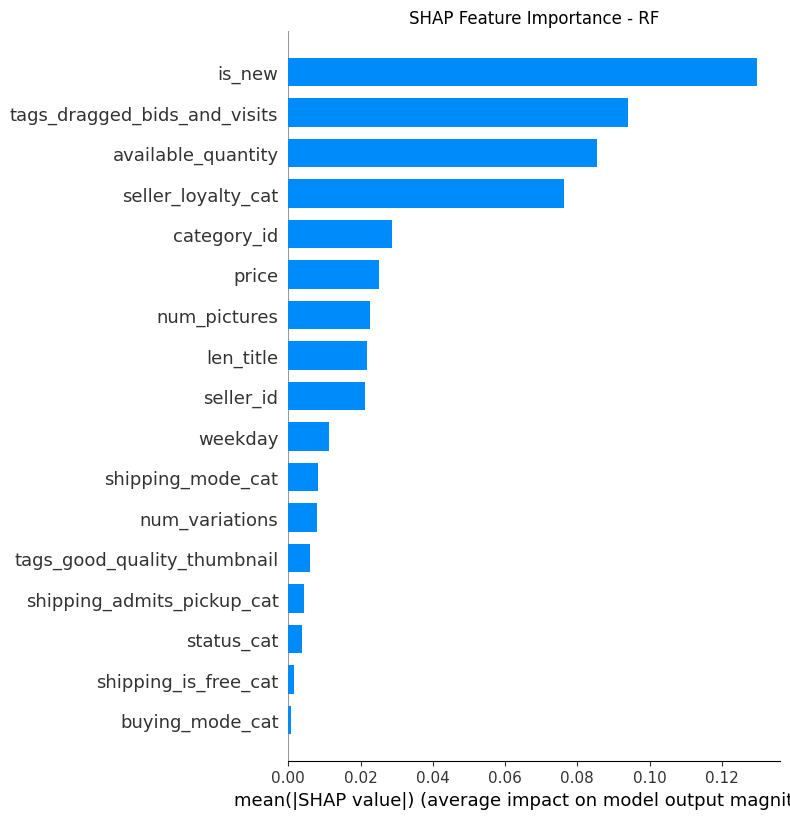

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - 
Importancia de caracter√≠sticas (ordenadas):
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - is_new: 0.1296
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - tags_dragged_bids_and_visits: 0.0940
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - available_quantity: 0.0854
2025-07-03 22:54:22,676 - src.models.model_predictor - INFO - seller_loyalty_cat: 0.0764
2025-07-03 22:54:22,678 - src.models.model_predictor - INFO - category_id: 0.0288
2025-07-03 22:54:22,680 - src.models.model_predictor - INFO - price: 0.0250
2025-07-03 22:54:22,681 - src.models.model_predictor - INFO - num_pictures: 0.0225
2025-07-03 22:54:22,682 - src.models.model_predictor - INFO - len_title: 0.0218
2025-07-03 22:54:22,682 - src.models.model_predictor - INFO - seller_id: 0.0212
2025-07-03 22:54:22,689 - src.models.model_predictor - INFO - weekday: 0.0112
2025-07-03 22:54:22,689 - src.models.model_predictor - INFO

In [19]:
# Genera explicaciones SHAP para el modelo Random Forest seleccionado, utilizando 100 muestras del dataset
# para analizar la importancia de las caracter√≠sticas y entender c√≥mo el modelo toma decisiones

predictor.explain_model(model_type='rf', n_samples=100)

In [20]:
# Hacer predicci√≥n con Random Forest
result = predictor.predict_random_sample(model_type='rf', random_state=42)
print(f"Probabilidad de clase 1: {result['predicted_proba']:.4f}")
print(f"Etiqueta verdadera: {result['true_label']}")
print("\nFeatures importantes:")
for feature, value in result['features'].items():
    print(f"- {feature}: {value}")

2025-07-04 01:09:54,086 - src.models.model_predictor - INFO - 
Predicci√≥n realizada con RF:
- Probabilidad de clase 1: 0.1264
- Etiqueta verdadera: 0
- Features importantes:



Probabilidad de clase 1: 0.1264
Etiqueta verdadera: 0

Features importantes:


## ‚úÖ RESUMEN DE EXPLICABILIDAD - MODELO RANDOM FOREST

### üìä IMPORTANCIA DE CARACTER√çSTICAS (Top 10)
1. **`is_new`**: `0.1296` ‚Äî Indica si el producto es nuevo  
2. **`tags_dragged_bids_and_visits`**: `0.0940` ‚Äî Se√±ales de interacci√≥n (clics, visitas, ofertas)  
3. **`available_quantity`**: `0.0854` ‚Äî Cantidad de unidades disponibles  
4. **`seller_loyalty_cat`**: `0.0764` ‚Äî Nivel de lealtad del vendedor  
5. **`category_id`**: `0.0288` ‚Äî Categor√≠a del producto  
6. **`price`**: `0.0250` ‚Äî Precio del producto  
7. **`num_pictures`**: `0.0225` ‚Äî N√∫mero de im√°genes publicadas  
8. **`len_title`**: `0.0218` ‚Äî Longitud del t√≠tulo del producto  
9. **`seller_id`**: `0.0212` ‚Äî Identificador del vendedor (puede captar efectos individuales)  
10. **`weekday`**: `0.0112` ‚Äî D√≠a de la semana en que se public√≥ el producto  

---

### üîç INSIGHTS PRINCIPALES

Las variables m√°s influyentes para predecir si un producto tendr√° al menos una venta est√°n relacionadas con:

- **Estado del producto** (`is_new`)  
- **Engagement previo** (`tags_dragged_bids_and_visits`)  
- **Disponibilidad de inventario** (`available_quantity`)  
- **Calidad o experiencia del vendedor** (`seller_loyalty_cat`)  
- **Precio, t√≠tulo e im√°genes**, que impactan la percepci√≥n visual y textual  

---

### üìà IMPLICACIONES DE NEGOCIO

- **Los productos nuevos tienden a tener mayor probabilidad de venta**, probablemente por mejor condici√≥n o novedad  
- **El engagement previo (clics, visitas, ofertas)** es una se√±al temprana √∫til: productos con tr√°fico tienen m√°s chances de vender  
- **Una alta disponibilidad aumenta la visibilidad y probabilidad de conversi√≥n**  
- **Vendedores leales aportan m√°s valor**, quiz√° por experiencia, confianza o buenas pr√°cticas  
- **Variables visuales y textuales** (fotos, t√≠tulo) tambi√©n son relevantes, aunque en menor medida  

---

### üéØ RECOMENDACIONES

1. **Promocionar productos nuevos** o etiquetarlos claramente como tales para incentivar confianza  
2. **Fomentar interacci√≥n temprana** con acciones de marketing que aumenten clics, visitas o visualizaciones  
3. **Asegurar buen inventario** para no frenar la demanda potencial  
4. **Fortalecer programas de fidelidad** para vendedores que ofrezcan buen servicio  
5. **Optimizar fotos, t√≠tulo y precio** para influir en la decisi√≥n de compra desde lo visual y sem√°ntico  
